<a href="https://colab.research.google.com/github/d4vidi4n/EL7006/blob/main/EL7006_T2_ITL_P1_Enunciado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> <center> EL7006 - Tarea Nº2 <br /> Information-Theoretic Learning  </center> </h1>
<h3> <center>Profesor: Pablo Estévez <br />
Profesor Auxiliar: Jhon Intriago <br />
Ayudantes: Sebastián Guzmán y Francisco Soto <br />
<h3><center>Semestre: Primavera 2025 </center></h3>

In [7]:
import os
os.chdir(r'D:\RN\Tarea_2_ITL')
# print(os.getcwd())
os.listdir(r'D:\RN\Tarea_2_ITL')

['código base', 'images', 'README.md', 'Tarea_2_ITL']

En esta tarea deberán contestar preguntas e implementar código relacionado a information-theoretic learning (ITL).

Para entregar su tarea, suba a u-cursos un archivo zip que contenga los notebooks de los problemas 1 y 2, desarrollados con sus respuestas e implementaciones, junto con cualquier archivo adicional necesario para ejecutarlos. Sea claro en sus respuestas, y comente adecuadamente su código. No es necesario redactar un informe.

<h1><center><u>Problema 1: Regresión por mínima entropía del error </u></center></h1>

Considere un modelo  
$$ f(x) = a x^2 + b x + c,$$
$$ z(x) = f(x) + \nu,$$
donde $\nu$ es la componente asociada al ruido y $z(x)$ son las observaciones ruidosas del modelo verdadero $f(x)$. La función de densidad de probabilidad (PDF) del ruido está dada por
$$p_{\nu}(\nu) = 0.8 ~\mathcal{N}(0,\ 0.1) + 0.2 ~ \mathcal{N}(10,\ 0.1),$$
que corresponde a una mezcla impulsiva de Gaussianas (modelo Middleton).

Usted tiene a su disposición pares $\{(x_i,\ z_i)\}_{i=1,\ldots,N}$. El objetivo es entrenar un aproximador parámetrico $g(x;w)$ de parámetros $w$ para recuperar los parámetros reales del sistema ($a$, $b$ y $c$). Para este problema, es útil monitorear el error intrínseco (IEP) del regresor, dado por
$$ \mathrm{IEP} = \frac{1}{N}\sum_{i=1}^N(f(x_i) - g(x_i;w))^2.$$

En el enfoque clásico, los parámetros $w$ del regresor se entrenan para minimizar el MSE. Es decir, se resuelve:
$$ w^*_{MSE} = \mathrm{arg}\min_w \frac{1}{N} \sum_{i=1}^N (z_i-g(x_i;w)) ^ 2.$$

En el marco ITL, el regresor se puede entrenar usando como criterio la Minimización de Entropía del Error (MEE). Esto es equivalente a maximizar el potencial de información, dado por
$$
\widehat{V}(e) = \frac{1}{N^2} \sum_{i=1}^N \sum_{j=1}^N G_{\sigma}(e_i - e_j) = \frac{1}{N^2} \frac{1}{\sqrt{2\pi}\sigma} \sum_{i=1}^N \sum_{j=1}^N \exp \left( -\frac{(e_i - e_j)^2}{2\sigma^2}\right),
$$
donde $\sigma$ es el ancho de banda del kernel Gaussiano y $e_i=z_i-g(x_i;w)$ es el error en la observación $i$-ésima. Es decir, se resuelve:
$$ w^*_{MEE} = \mathrm{arg}\max_w \widehat{V}(e).$$

En este problema, usted implementar y entrenar regresores para optimizar los criterios MSE y MEE por gradiente descendente, y debe comparar la precisión con que $w^*_{MSE}$ y $w^*_{MEE}$ se ajustan a los parámetros reales del sistema. Para esto, se consideran dos escenarios: uno sin término constante ($c=0$) y otro con término costante ($c\not=0$).

In [11]:
import matplotlib.pylab as plt
import numpy as np
from sklearn.neighbors import KernelDensity
%matplotlib inline

<h2>Caso 1: Modelo sin término constante</h2>

Considere el modelo dado por $a=-2$, $b=10$ y $c=0$. Para este modelo, considere el siguiente aproximador paramétrico
$$ g(x;w) = w_2x^2 + w_1x.$$
Es decir, el regresor tiene dos parámetros, $w_2$ y $w_1$, que buscan ajustar $a$ y $b$, respectivamente.

A continuación, se generan $N=100$ muestras de $z$.

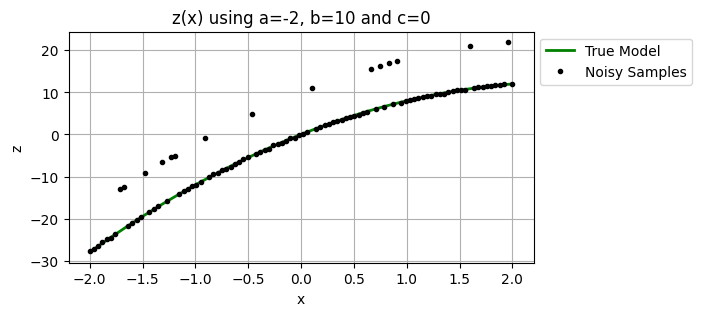

In [19]:
# Parameters of the quadratic model
a = -2
b = 10
c = 0
# Sample generation (Random but reproducible)
N = 100
x = np.linspace(-2.0, 2.0, num=N)
fx = a * x ** 2 + b * x + c
noise = 0.1 * np.random.RandomState(seed=0).randn(N,)
noise[np.random.RandomState(seed=0).rand(N,) > 0.8] += 10.0
z = fx + noise
# Visualization
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=100)
ax.plot(x, fx, 'g-', label='True Model', linewidth=2)
ax.plot(x, z, 'k.', label='Noisy Samples')
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.grid()
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title("z(x) using a=%s, b=%s and c=%s" % (a, b, c))
plt.show()

<h2>Regresor con criterio MSE</h2>

Implemente el regresor usando MSE como función de costo y gradiente descendente como optimizador, evaluando todas las muestras disponibles ($N=100$) en cada iteración. Los pesos $w$ se inicializan uniformemente en el intervalo (0,1).

Instrucciones de programación:
- Es libre de elegir la librería de su preferencia para implementar el regresor. Se recomienda Tensorflow o Pytorch. También puede implementar el regresor de forma manual con Numpy si así lo desea.
- Debe implementar su regresor en una clase llamada "QuadraticModelMSE_Case1".
- La clase debe implementar un método "fit" que recibe las entradas $x$, las observaciones $z$, y los valores verdaderos del modelo $f_x=f(x)$. Debe entrenar usando $(x,\ z)$ y monitorear el error intrínseco (IEP) usando $f_x$. Al finalizar el entrenamiento, debe retornar la evolución del IEP a lo largo de las iteraciones.
- La clase debe implementar un método "get_weights" para recuperar los parámetros ajustados $w^*_{MSE}$.
- Es libre de implementar métodos adicionales si lo desea.

Implemente su modelo en la siguiente celda. Sea ordenado y claro en su código. Comente adecuadamente. Elija nombres significativos para sus variables.

In [23]:
# Sustituye esto:
!pip install early-stopping-pytorch
!pip install pytorch-ignite

from ignite.handlers import EarlyStopping
from ignite.metrics import Loss
from early_stopping_pytorch import EarlyStopping


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
import torch
import torch.nn as nn

device = torch.device('cuda')
criterion = torch.nn.MSELoss()

In [119]:
class QuadraticModelMSE_Case1():
    def __init__(self, learning_rate, n_iterations):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.hidden_size = 24
        self.input_size = 100
        self.output_size = 2

        # Weights initialized from Uniform(0, 1), random but reproducible
        self.w1 = np.random.RandomState(seed=1).rand()
        self.w2 = np.random.RandomState(seed=2).rand()

        # --- Your code goes here ---
        # Neural network Layers
        self.input_layer = nn.Linear(self.input_size, self.hidden_size)
        self.hidden_layer = nn.Linear(self.hidden_size, self.hidden_size)
        self.output_layer = nn.Linear(self.hidden_size, self.output_size)

        # Neural network
        self.model = nn.Sequential(self.input_layer, nn.ReLU(),
                                   self.hidden_layer, nn.ReLU(),
                                   self.output_layer)

        # Optimizer
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate, betas=(0.9, 0.999))

    def fit(self, x, z, fx):
        # --- Your code goes here ---
        loss_train = []
        loss_val = []
        iep_curve = []

        self.model.to(device)
        # self.optimizer.to(device)

        x = torch.from_numpy(x).float().to(device)
        z = torch.from_numpy(z).float().to(device)
        fx = torch.from_numpy(fx).float().to(device)

        for i in range(self.n_iterations):
            #Entrenamiento
            self.model.train()

            self.optimizer.zero_grad()

            #Predicciones
            output = self.model(x)

            # w1 y w2 como promedio de toda la batch
            self.w1 = output[0]
            self.w2 = output[1]

            # Polynomial prediction
            pol_value_with_coefs_in_this_iteration = self.w2 * x**2 + self.w1 * x

            #Loss backward
            loss = criterion(pol_value_with_coefs_in_this_iteration, z)
            loss.backward()

            loss_train.append((criterion(pol_value_with_coefs_in_this_iteration, z)).item())
            iep_curve.append((criterion(pol_value_with_coefs_in_this_iteration, fx)).item())

            self.optimizer.step()

            # Evaluación
            with torch.no_grad():

                self.model.eval()

                output = self.model(x)

                pol_value_with_coefs_in_this_iteration = self.w2*x**2 + self.w1*x

                loss_val.append((criterion(pol_value_with_coefs_in_this_iteration, z)).item())

        iep_curve = iep_curve
        return iep_curve

    def get_weights(self):
        return self.w1.detach().cpu().item(), self.w2.detach().cpu().item()

Con su modelo ya implementado, es hora de entrenar. Se solicita entrenar su modelo usando una tasa de aprendizaje 0.02 y 1000 iteraciones. Luego de entrenar su modelo, se reporta:
- Los valores de los parámetros ajustados $w^*_{MSE}$, y su desviación porcentual con respecto a los parámetros intrínsecos del sistema.
- El ajuste $g(x;w^*_{MSE})$ vs $x$ obtenido por el regresor comparado con las observaciones y el modelo real.
- Evolución del error intrínseco (IEP).

Considere estos resultados como referencia para comparar con el regresor MEE.

9.74668025970459 -1.316920518875122


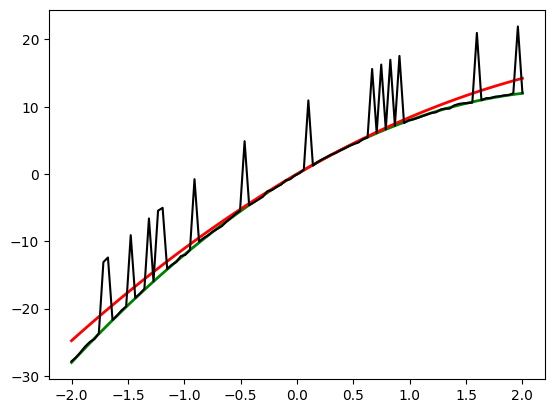

In [128]:
regressor = QuadraticModelMSE_Case1(0.02, 100)
iep_curve = regressor.fit(x, z, fx)
w_1_mse, w_2_mse = regressor.get_weights()
print(w_1_mse, w_2_mse)
# plt.plot(iep_curve)
fx_predicted = w_2_mse * x ** 2 + w_1_mse * x
plt.plot(x, fx, 'g-', label='True Model', linewidth=2)
plt.plot(x, fx_predicted, 'r-', label='Predicted Model', linewidth=2)
plt.plot(x, z, 'k-', label='Noisy Samples')

# plot.show(

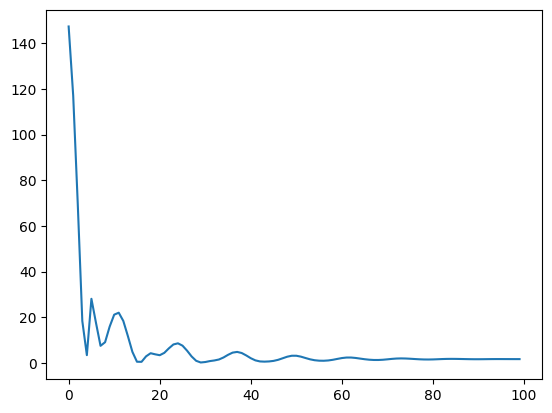

In [ ]:
# Adjusted weights
print("Case 1 with MSE:")
print("True parameter a = %d. Adjusted parameter W2 = %1.4f. Deviation %1.2f%%." % (
    a, w_2_mse, 100 * np.abs((w_2_mse - a) / a)))
print("True parameter b = %d. Adjusted parameter W1 = %1.4f. Deviation %1.2f%%." % (
    b, w_1_mse, 100 * np.abs((w_1_mse - b) / b)))

In [ ]:
# Fitting visualization
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=100)
ax.plot(x, fx, 'g-', label='True Model', linewidth=2)
ax.plot(x, z, 'k.', label='Noisy Samples')
output_mse = w_2_mse * x ** 2 + w_1_mse * x
ax.plot(x, output_mse, label='MSE', linewidth=3, alpha=.5)
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.grid()
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title("z(x) using a=%s, b=%s and c=%s" % (a, b, c))
plt.show()

In [ ]:
# --- Your plot of IEP evolution goes here ---


<h2>Regresor con criterio MEE</h2>

Ahora implemente el regresor usando MEE como función de costo y gradiente descendente como optimizador, evaluando todas las muestras disponibles en cada iteración. Para inicializar los pesos $w$, primero entrene usando MSE por un cierto número de iteraciones a partir de pesos inicializados uniformemente en el intervalo (0,1). A partir de estos pesos pre-entrenados, siga entrenando usando MEE por otro número dado de iteraciones. Note que el regresor basado en MEE también requiere la especificación del ancho de banda del kernel Gaussiano $\sigma$.

Las instrucciones de programación son las mismas que para el caso de MSE, a excepción del nombre de la clase que esta vez debe ser "QuadraticModelMEE_Case1".

Implemente su modelo en la siguiente celda. Sea ordenado y claro en su código. Comente adecuadamente. Elija nombres significativos para sus variables.

In [ ]:
class QuadraticModelMEE_Case1():
    def __init__(
        self,
        learning_rate_mse, n_iterations_mse,
        learning_rate_mee, n_iterations_mee,
        kernel_width
    ):
        self.learning_rate_mse = learning_rate_mse
        self.n_iterations_mse = n_iterations_mse
        self.learning_rate_mee = learning_rate_mee
        self.n_iterations_mee = n_iterations_mee
        self.kernel_width = kernel_width

        # Weights initialized from Uniform(0, 1), random but reproducible
        self.w1 = np.random.RandomState(seed=1).rand()
        self.w2 = np.random.RandomState(seed=2).rand()

        # --- Your code goes here ---

    def fit(self, x, z, fx):
        # --- Your code goes here ---
        iep_curve = None
        return iep_curve

    def get_weights(self):
        return self.w1, self.w2

Con su modelo ya implementado, es hora de entrenar. Para ello, primero entrene con MSE por 200 iteraciones con tasa de aprendizaje 0.02. Después, proceda a entrenar con MEE por 800 iteraciones con tasa de aprendizaje 1.0. Luego de entrenar su modelo, se reporta:
- Los valores de los parámetros ajustados $w^*_{MEE}$, y su desviación porcentual con respecto a los parámetros intrínsecos del sistema.
- El ajuste $g(x;w^*_{MEE})$ vs $x$ obtenido por el regresor comparado con las observaciones y el modelo real.
- Evolución del error intrínseco (IEP).

Reporte estos resultados para los anchos de banda $\sigma\in\{0.2,\ 2,\ 20\}$.

In [ ]:
kernel_width_grid = [0.2, 2, 20]
iep_curve_list = []
w_1_mee_list = []
w_2_mee_list = []
for kernel_width in kernel_width_grid:
    regressor = QuadraticModelMEE_Case1(0.02, 200, 1.0, 800, kernel_width)
    iep_curve = regressor.fit(x, z, fx)
    w_1_mee, w_2_mee = regressor.get_weights()
    # Save results for reports
    iep_curve_list.append(iep_curve)
    w_1_mee_list.append(w_1_mee)
    w_2_mee_list.append(w_2_mee)

In [ ]:
# Adjusted weights
for w_1_mee, w_2_mee, kernel_width in zip(w_1_mee_list, w_2_mee_list, kernel_width_grid):
    print("\nCase 1 with MEE and kernel width %1.1f:" % kernel_width)
    print("True parameter a = %d. Adjusted parameter W2 = %1.4f. Deviation %1.2f%%." % (
        a, w_2_mee, 100 * np.abs((w_2_mee - a) / a)))
    print("True parameter b = %d. Adjusted parameter W1 = %1.4f. Deviation %1.2f%%." % (
        b, w_1_mee, 100 * np.abs((w_1_mee - b) / b)))

In [ ]:
# Fitting visualization
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=100)
ax.plot(x, fx, 'g-', label='True Model', linewidth=2)
ax.plot(x, z, 'k.', label='Noisy Samples')
for w_1_mee, w_2_mee, kernel_width in zip(w_1_mee_list, w_2_mee_list, kernel_width_grid):
    output_mee = w_2_mee * x ** 2 + w_1_mee * x
    ax.plot(x, output_mee, label=r'MEE ($\sigma$ = %1.1f)' % kernel_width, linewidth=3, alpha=.5)
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.grid()
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title("z(x) using a=%s, b=%s and c=%s" % (a, b, c))
plt.show()

In [ ]:
# --- Your plot of IEP evolution goes here ---


<h2>PDF del error intrínseco</h2>

A continuación se muestra la PDF del error intrínseco de cada regresor entrenado, ajustada a partir de las muestras usando KDE.

In [ ]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.2)
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=100)
x_plot = np.linspace(-10, 10, 1000)[:, np.newaxis]
# Adjust KDE for MSE
output_mse = w_2_mse * x ** 2 + w_1_mse * x
intrinsic_error = fx - output_mse
kde.fit(intrinsic_error[:, np.newaxis])
ax.plot(x_plot, np.exp(kde.score_samples(x_plot)), label='MSE', linewidth=4, alpha=.5)
# Adjust KDE for MEE
for w_1_mee, w_2_mee, kernel_width in zip(w_1_mee_list, w_2_mee_list, kernel_width_grid):
    output_mee = w_2_mee * x ** 2 + w_1_mee * x
    intrinsic_error = fx - output_mee
    kde.fit(intrinsic_error[:, np.newaxis])
    ax.plot(x_plot, np.exp(kde.score_samples(x_plot)),
            label=r'MEE ($\sigma$ = %1.1f)' % kernel_width, linewidth=3, alpha=.5)
ax.set_xlabel('Intrinsic error')
ax.set_ylabel('PDF of the error');
ax.set_title("Comparison of PDFs obtained by different regressors")
ax.grid()
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

<h2>Preguntas del Caso 1</h2>

- Siendo $E$ el error, relacione matemáticamente el potencial de información y la esperanza de la PDF del error $\mathbb{E}[p_E(E)]$. Para ello, primero exprese la entropía cuadrática $H_2(E)=-\log\left(\int p_E(e)^2\mathrm{d}e \right)$ en términos de la esperanza de la PDF del error. Después, exprese $H_2(E)$ en términos del potencial de información, y concluya.

<font color='red'>Respuesta:</font> Lorem ipsum.

- Basado en su expresión anterior, muestre gráficamente lo que implica minimizar y maximizar el potencial de información en la PDF del error. Compare con el criterio de mínimo MSE. ¿En qué casos el criterio de mínima entropía es superior al mínimo MSE? ¿Por qué?

<font color='red'>Respuesta:</font> Lorem ipsum.

- ¿Con cuál valor de $\sigma$ se obtiene un mejor desempeño en MEE (mínimo error intrínseco al final del entrenamiento)? ¿Cuál es el rol del ancho de banda? ¿Qué criterios existen para seleccionar este parámetro? Justifique sus respuesta basándose en la teoría.

<font color='red'>Respuesta:</font> Lorem ipsum.

- Compare el mejor regresor MEE con el regresor MSE en términos de la evolución del error intrínseco, parámetros obtenidos y calidad del regresor. ¿Cuál regresor es más robusto al ruido impulsivo de este problema? Explique por qué.

<font color='red'>Respuesta:</font> Lorem ipsum.

- Comente sobre las diferencias observadas en las gráficas de la PDF del error intrínseco para el regresor MSE y el mejor regresor MEE, justificando según la teoría.

<font color='red'>Respuesta:</font> Lorem ipsum.

<h2>Caso 2: Modelo con término constante</h2>

Considere ahora el modelo dado por $a=-2$, $b=10$ y $c=5$. Note la inclusión de un término constante no nulo. Para este modelo, considere ahora el siguiente aproximador paramétrico
$$ g(x;w) = w_2x^2 + w_1x + w_0.$$
Es decir, el regresor tiene tres parámetros, $w_2$, $w_1$ y $w_0$, que buscan ajustar $a$, $b$ y $c$, respectivamente.

A continuación, se generan $N=100$ muestras de $z$.

In [ ]:
# Parameters of the quadratic model
a = -2
b = 10
c = 5
# Sample generation (Random but reproducible)
N = 100
x = np.linspace(-2.0, 2.0, num=N)
fx = a * x ** 2 + b * x + c
noise = 0.1 * np.random.RandomState(seed=0).randn(N,)
noise[np.random.RandomState(seed=0).rand(N,) > 0.8] += 10.0
z = fx + noise
# Visualization
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=100)
ax.plot(x, fx, 'g-', label='True Model', linewidth=2)
ax.plot(x, z, 'k.', label='Noisy Samples')
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.grid()
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title("z(x) using a=%s, b=%s and c=%s" % (a, b, c))
plt.show()

<h2>Regresor con criterio MSE</h2>

Implemente un regresor MSE para el caso 2 en la clase "QuadraticModelMSE_Case2" usando las mismas instrucciones que para el caso 1. Note que ahora el regresor debe ajustar tres parámetros en lugar de dos.


In [ ]:
class QuadraticModelMSE_Case2():
    def __init__(self, learning_rate, n_iterations):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations

        # Weights initialized from Uniform(0, 1), random but reproducible
        self.w0 = np.random.RandomState(seed=0).rand()
        self.w1 = np.random.RandomState(seed=1).rand()
        self.w2 = np.random.RandomState(seed=2).rand()

        # --- Your code goes here ---

    def fit(self, x, z, fx):
        # --- Your code goes here ---
        iep_curve = None
        return iep_curve

    def get_weights(self):
        return self.w0, self.w1, self.w2

In [ ]:
regressor = QuadraticModelMSE_Case2(0.02, 1000)
iep_curve = regressor.fit(x, z, fx)
w_0_mse, w_1_mse, w_2_mse = regressor.get_weights()

In [ ]:
# Adjusted weights
print("Case 2 with MSE:")
print("True parameter a = %d. Adjusted parameter W2 = %1.4f. Deviation %1.2f%%." % (
    a, w_2_mse, 100 * np.abs((w_2_mse - a) / a)))
print("True parameter b = %d. Adjusted parameter W1 = %1.4f. Deviation %1.2f%%." % (
    b, w_1_mse, 100 * np.abs((w_1_mse - b) / b)))
print("True parameter c = %d. Adjusted parameter W0 = %1.4f. Deviation %1.2f%%." % (
    c, w_0_mse, 100 * np.abs((w_0_mse - c) / c)))

In [ ]:
# Fitting visualization
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=100)
ax.plot(x, fx, 'g-', label='True Model', linewidth=2)
ax.plot(x, z, 'k.', label='Noisy Samples')
output_mse = w_2_mse * x ** 2 + w_1_mse * x + w_0_mse
ax.plot(x, output_mse, label='MSE', linewidth=3, alpha=.5)
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.grid()
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title("z(x) using a=%s, b=%s and c=%s" % (a, b, c))
plt.show()

In [ ]:
# --- Your plot of IEP evolution goes here ---


<h2>Regresor con criterio MEE</h2>

Implemente un regresor MEE para el caso 2 en la clase "QuadraticModelMEE_Case2" usando las mismas instrucciones que para el caso 1. Por simplicidad, solo utilice el mejor ancho de banda encontrado en el caso 1. El criterio MEE no permite ajustar $w_0$. Compense manualmente este parámetro a lo largo del entrenamiento.

In [ ]:
class QuadraticModelMEE_Case2():
    def __init__(
        self,
        learning_rate_mse, n_iterations_mse,
        learning_rate_mee, n_iterations_mee,
        kernel_width
    ):
        self.learning_rate_mse = learning_rate_mse
        self.n_iterations_mse = n_iterations_mse
        self.learning_rate_mee = learning_rate_mee
        self.n_iterations_mee = n_iterations_mee
        self.kernel_width = kernel_width

        # Weights initialized from Uniform(0, 1), random but reproducible
        self.w0 = np.random.RandomState(seed=0).rand()
        self.w1 = np.random.RandomState(seed=1).rand()
        self.w2 = np.random.RandomState(seed=2).rand()

        # --- Your code goes here ---

    def fit(self, x, z, fx):
        # --- Your code goes here ---
        iep_curve = None
        return iep_curve

    def get_weights(self):
        return self.w0, self.w1, self.w2

In [ ]:
best_kernel_width = 1000
regressor = QuadraticModelMEE_Case2(0.02, 200, 1.0, 800, best_kernel_width)
iep_curve = regressor.fit(x, z, fx)
w_0_mee, w_1_mee, w_2_mee = regressor.get_weights()

In [ ]:
# Adjusted weights
print("Case 2 with MEE and kernel width %1.1f:" % best_kernel_width)
print("True parameter a = %d. Adjusted parameter W2 = %1.4f. Deviation %1.2f%%." % (
    a, w_2_mee, 100 * np.abs((w_2_mee - a) / a)))
print("True parameter b = %d. Adjusted parameter W1 = %1.4f. Deviation %1.2f%%." % (
    b, w_1_mee, 100 * np.abs((w_1_mee - b) / b)))
print("True parameter c = %d. Adjusted parameter W0 = %1.4f. Deviation %1.2f%%." % (
    c, w_0_mee, 100 * np.abs((w_0_mee - c) / c)))

In [ ]:
# Fitting visualization
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=100)
ax.plot(x, fx, 'g-', label='True Model', linewidth=2)
ax.plot(x, z, 'k.', label='Noisy Samples')
output_mee = w_2_mee * x ** 2 + w_1_mee * x + w_0_mee
ax.plot(x, output_mee, label='MEE', linewidth=3, alpha=.5)
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.grid()
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title("z(x) using a=%s, b=%s and c=%s" % (a, b, c))
plt.show()

In [ ]:
# --- Your plot of IEP evolution goes here ---


<h2>PDF del error intrínseco</h2>

A continuación se muestra la PDF del error intrínseco de cada regresor entrenado, ajustada a partir de las muestras usando KDE.

In [ ]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.2)
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=100)
x_plot = np.linspace(-10, 10, 1000)[:, np.newaxis]
# Adjust KDE for MSE
output_mse = w_2_mse * x ** 2 + w_1_mse * x + w_0_mse
intrinsic_error = fx - output_mse
kde.fit(intrinsic_error[:, np.newaxis])
ax.plot(x_plot, np.exp(kde.score_samples(x_plot)), label='MSE', linewidth=4, alpha=.5)
# Adjust KDE for MEE
output_mee = w_2_mee * x ** 2 + w_1_mee * x + w_0_mee
intrinsic_error = fx - output_mee
kde.fit(intrinsic_error[:, np.newaxis])
ax.plot(x_plot, np.exp(kde.score_samples(x_plot)), label="MEE", linewidth=3, alpha=.5)
ax.set_xlabel('Intrinsic error')
ax.set_ylabel('PDF of the error');
ax.set_title("Comparison of PDFs obtained by different regressors")
ax.grid()
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

<h2>Preguntas del Caso 2</h2>

- Calcule la derivada respecto a $w_0$, $w_1$ y $w_2$ del potencial de información.

<font color='red'>Respuesta:</font> Lorem ipsum.

- Explique por qué el criterio MEE no permite ajustar por sí solo el parámetro asociado al término constante mientras que el criterio MSE sí. ¿Qué ocurre si no se compensa este parámetro? ¿De qué forma se compensa?

<font color='red'>Respuesta:</font> Lorem ipsum.